In [1]:
import pandas as pd

df_flights = pd.read_csv("flights.csv")
df_flights.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35,1.0,1027,33,1,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0


#### CLEANING MISSING VALUES

In [2]:
df_flights.isnull().sum()

Year                    0
Month                   0
DayofMonth              0
DayOfWeek               0
Carrier                 0
OriginAirportID         0
OriginAirportName       0
OriginCity              0
OriginState             0
DestAirportID           0
DestAirportName         0
DestCity                0
DestState               0
CRSDepTime              0
DepDelay                0
DepDel15             2761
CRSArrTime              0
ArrDelay                0
ArrDel15                0
Cancelled               0
dtype: int64

Hmm, looks like there are some null "late departure" indicators. Departures are considered late if the delay is 15 minutes or more, so let's see the delays for the ones with a null late indicator:

In [3]:
df_flights[df_flights.isnull().any(axis = 1)][['DepDelay','DepDel15']]

,DepDelay,DepDel15
171,0,NaN
359,0,NaN
429,0,NaN
545,0,NaN
554,0,NaN
...,...,...
271410,0,NaN
271607,0,NaN
271634,0,NaN
271671,0,NaN


We can't see them all in this display, but it looks like they may all have delay of 0. Let's check by looking at the summary statistics for these records:

In [4]:
df_flights[df_flights.isnull().any(axis = 1)].DepDelay.describe()

count    2761.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: DepDelay, dtype: float64

The min, max, and mean are all 0; so it seems that none of these were actually late departures. Let's replace the missing DepDel15 indicator with a 0 and confirm there are no more missing values.

In [5]:
df_flights.DepDel15 = df_flights.DepDel15.fillna(0)
df_flights.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
Carrier              0
OriginAirportID      0
OriginAirportName    0
OriginCity           0
OriginState          0
DestAirportID        0
DestAirportName      0
DestCity             0
DestState            0
CRSDepTime           0
DepDelay             0
DepDel15             0
CRSArrTime           0
ArrDelay             0
ArrDel15             0
Cancelled            0
dtype: int64

#### Clean outliers
View the distribution and summary statistics for the DepDelay and ArrDelay columns.

In [7]:
from matplotlib.pyplot import plot as plt

DepDelay 
Minimum:-63.00
Mean:10.35
Median:-1.00
Mode:-3.00
Maximum:1425.00



C:\Users\v.desai\AppData\Local\Temp\ipykernel_5232\434812748.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\v.desai\AppData\Local\Temp\ipykernel_5232\434812748.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ArrDelay 
Minimum:-75.00
Mean:6.50
Median:-3.00
Mode:0.00
Maximum:1440.00



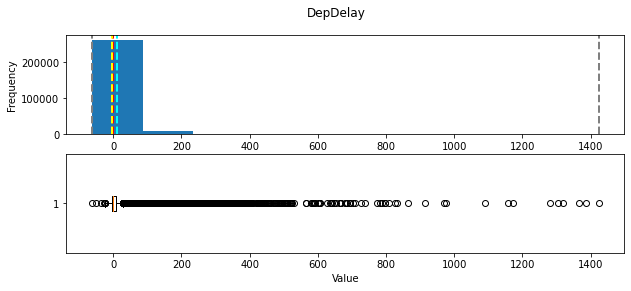

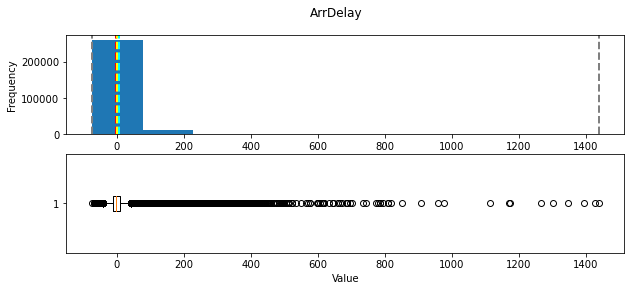

In [9]:
# Function to show summary stats and distribution for a column
def show_distribution(var_data):
    from matplotlib import pyplot as plt

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(var_data.name,'\nMinimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

    # Show the figure
    fig.show()

# Call the function for each delay field
delayFields = ['DepDelay','ArrDelay']
for col in delayFields:
    show_distribution(df_flights[col])

There are a outliers at the lower and upper ends of both variables - particularly at the upper end.

Let's trim the data so that we include only rows where the values for these fields are within the 1st and 90th percentile.

DepDelay 
Minimum:-11.00
Mean:-0.92
Median:-2.00
Mode:-3.00
Maximum:16.00

ArrDelay 
Minimum:-32.00
Mean:-5.03
Median:-6.00
Mode:0.00
Maximum:37.00



C:\Users\v.desai\AppData\Local\Temp\ipykernel_5232\434812748.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\v.desai\AppData\Local\Temp\ipykernel_5232\434812748.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


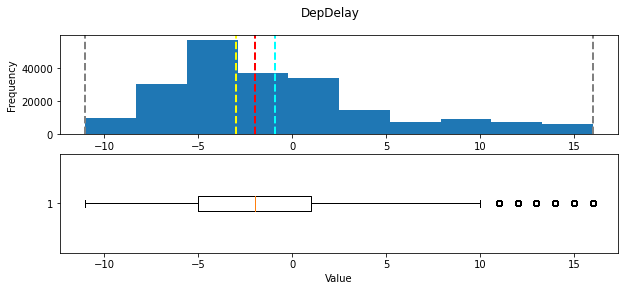

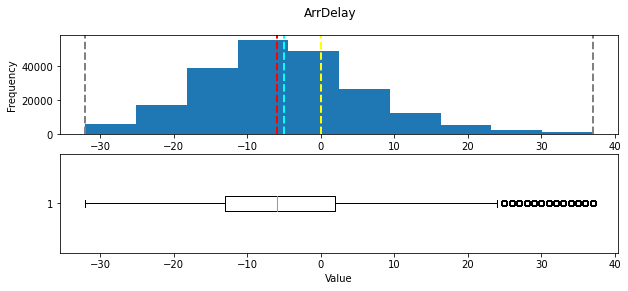

In [10]:
# Trim outliers for ArrDelay based on 1% and 90% percentiles
ArrDelay_01pcntile = df_flights.ArrDelay.quantile(0.01)
ArrDelay_90pcntile = df_flights.ArrDelay.quantile(0.90)
df_flights = df_flights[df_flights.ArrDelay < ArrDelay_90pcntile]
df_flights = df_flights[df_flights.ArrDelay > ArrDelay_01pcntile]

# Trim outliers for DepDelay based on 1% and 90% percentiles
DepDelay_01pcntile = df_flights.DepDelay.quantile(0.01)
DepDelay_90pcntile = df_flights.DepDelay.quantile(0.90)
df_flights = df_flights[df_flights.DepDelay < DepDelay_90pcntile]
df_flights = df_flights[df_flights.DepDelay > DepDelay_01pcntile]

# View the revised distributions
for col in delayFields:
    show_distribution(df_flights[col])

That looks a bit better.

#### Explore the data
Let's start with an overall view of the summary statistics for the numeric columns.

In [11]:
df_flights.describe()

,Year,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
count,214397.0,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000,214397.000000
mean,2013.0,7.018368,15.794703,3.902737,12757.827661,12726.276147,1278.223879,-0.921692,0.018116,1461.406596,-5.030276,0.068602,0.013228
std,0.0,2.006398,8.859118,1.997744,1510.058629,1506.251757,469.440262,5.708594,0.133371,485.676457,11.424280,0.252776,0.114249
min,2013.0,4.000000,1.000000,1.000000,10140.000000,10140.000000,1.000000,-11.000000,0.000000,1.000000,-32.000000,0.000000,0.000000
25%,2013.0,5.000000,8.000000,2.000000,11292.000000,11292.000000,850.000000,-5.000000,0.000000,1054.000000,-13.000000,0.000000,0.000000
50%,2013.0,7.000000,16.000000,4.000000,12892.000000,12892.000000,1235.000000,-2.000000,0.000000,1445.000000,-6.000000,0.000000,0.000000
75%,2013.0,9.000000,23.000000,6.000000,14100.000000,14057.000000,1655.000000,1.000000,0.000000,1845.000000,2.000000,0.000000,0.000000
max,2013.0,10.000000,31.000000,7.000000,15376.000000,15376.000000,2359.000000,16.000000,1.000000,2359.000000,37.000000,1.000000,1.000000


#### What are the mean departure and arrival delays?

In [12]:
df_flights[delayFields].mean()

DepDelay   -0.921692
ArrDelay   -5.030276
dtype: float64

In [13]:
df_flights.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0
6,2013,10,6,7,WN,13796,Metropolitan Oakland International,Oakland,CA,12191,William P Hobby,Houston,TX,630,-1,0.0,1210,-3,0,0


#### How do the carriers compare in terms of arrival delay performance?

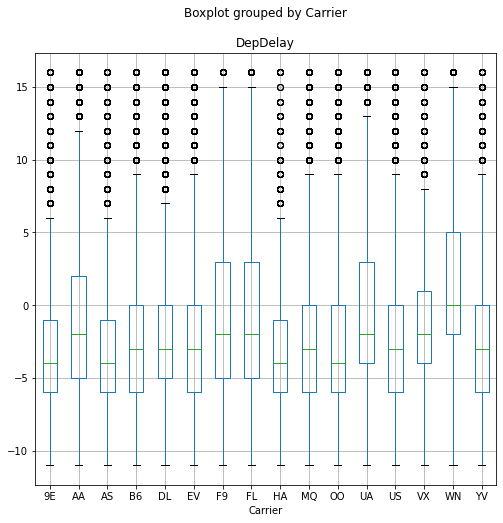

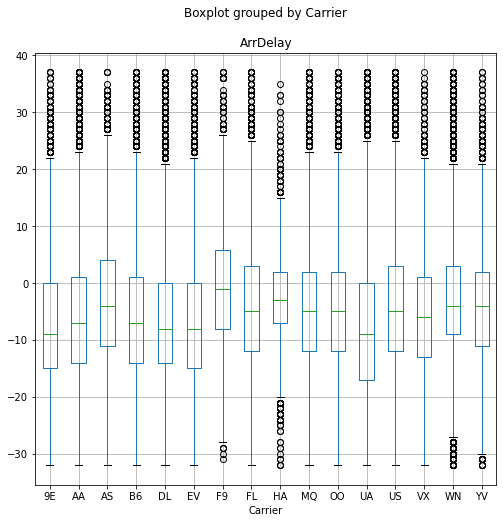

In [14]:
for col in delayFields:
    df_flights.boxplot(column=col, by='Carrier', figsize=(8,8))


#### Are some days of the week more prone to arrival days than others?

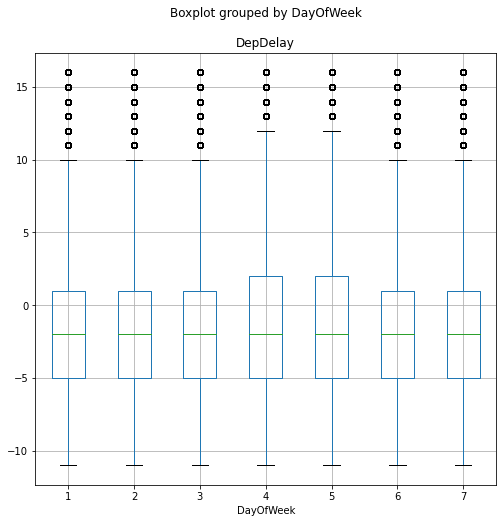

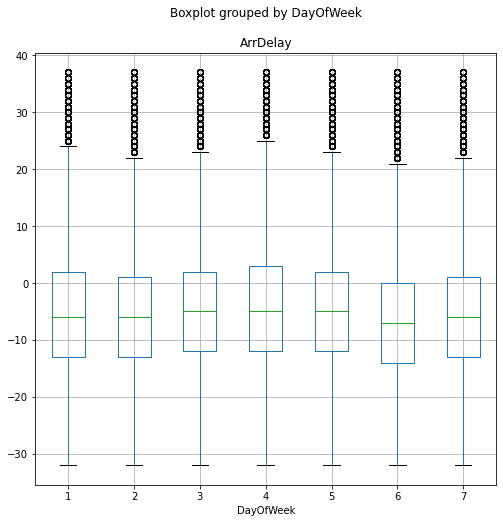

In [15]:
for col in delayFields:
    df_flights.boxplot(column=col, by='DayOfWeek', figsize=(8,8))

#### Which departure airport has the highest average departure delay?

,DepDelay
OriginAirportName,
Chicago Midway International,2.365960
Dallas Love Field,2.148798
William P Hobby,1.561927
Metropolitan Oakland International,0.964853
Denver International,0.807272
...,...
Memphis International,-2.962737
Tucson International,-2.989154
Ted Stevens Anchorage International,-3.149758


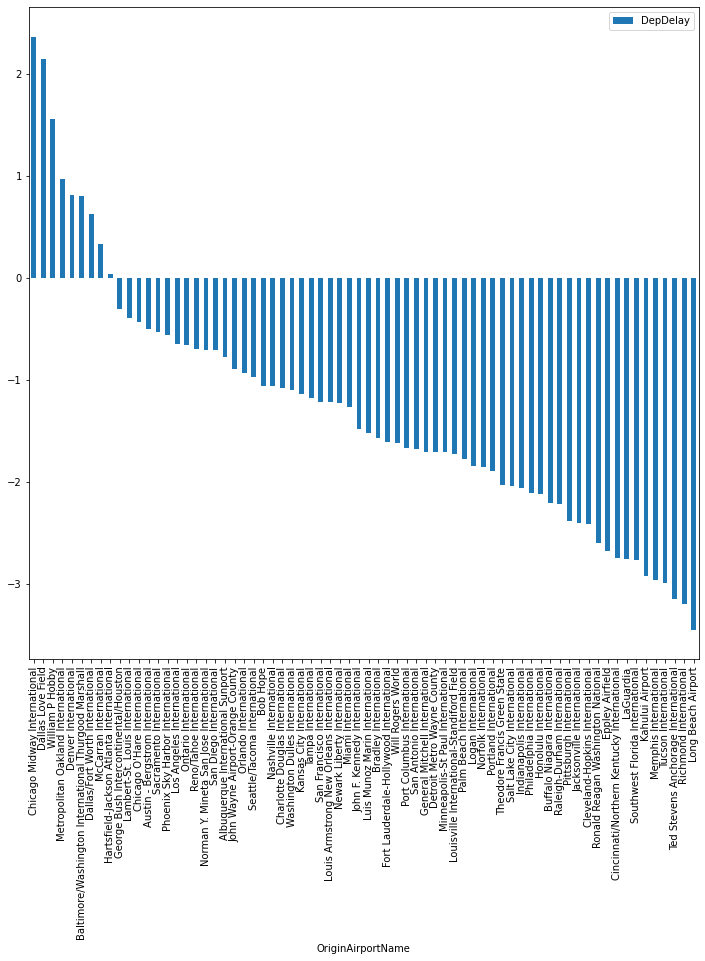

In [16]:
departure_airport_group = df_flights.groupby(df_flights.OriginAirportName)

mean_departure_delays = pd.DataFrame(departure_airport_group['DepDelay'].mean()).sort_values('DepDelay', ascending=False)
mean_departure_delays.plot(kind = "bar", figsize=(12,12))
mean_departure_delays

#### Do late departures tend to result in longer arrival delays than on-time departures?

<AxesSubplot:title={'center':'ArrDelay'}, xlabel='DepDel15'>

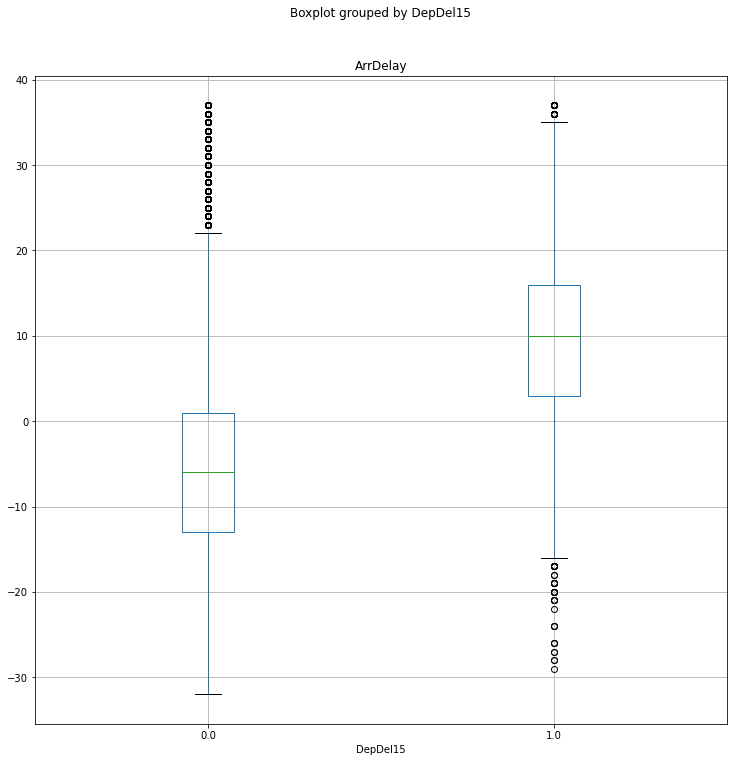

In [17]:
df_flights.boxplot(column='ArrDelay', by='DepDel15', figsize=(12,12))

#### Which route (from origin airport to destination airport) has the most late arrivals?

In [18]:
# Add a routes column
routes  = pd.Series(df_flights['OriginAirportName'] + ' > ' + df_flights['DestAirportName'])
df_flights = pd.concat([df_flights, routes.rename("Route")], axis=1)

# Group by routes
route_group = df_flights.groupby(df_flights.Route)
pd.DataFrame(route_group['ArrDel15'].sum()).sort_values('ArrDel15', ascending=False)

,ArrDel15
Route,
San Francisco International > Los Angeles International,90
Los Angeles International > San Francisco International,69
LaGuardia > Hartsfield-Jackson Atlanta International,68
Los Angeles International > John F. Kennedy International,52
LaGuardia > Charlotte Douglas International,51
...,...
Logan International > Austin - Bergstrom International,0
Logan International > Memphis International,0
Logan International > Port Columbus International,0


#### Which route has the highest average arrival delay?

In [19]:
pd.DataFrame(route_group['ArrDelay'].mean()).sort_values('ArrDelay', ascending=False)

,ArrDelay
Route,
Louis Armstrong New Orleans International > Ronald Reagan Washington National,24.500000
Cleveland-Hopkins International > Palm Beach International,18.000000
John F. Kennedy International > Louisville International-Standiford Field,18.000000
Cleveland-Hopkins International > Philadelphia International,12.800000
Memphis International > Denver International,9.758621
...,...
Lambert-St. Louis International > Cleveland-Hopkins International,-20.000000
Eppley Airfield > LaGuardia,-20.750000
Denver International > Kahului Airport,-22.666667
